In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import cartopy.crs as ccrs
from ipywidgets import interact, SelectionSlider
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [23]:
ls data

test_PSL.nc    test_V_500.nc	   train_TMQ.nc    train_precip.csv
test_TMQ.nc    test_precip.csv	   train_TS.nc	   train_precip_90.csv
test_TS.nc     test_precip_90.csv  train_U_500.nc
test_U_500.nc  train_PSL.nc	   train_V_500.nc


In [2]:
data_vars = ["TS", "PSL", "TMQ", "U_500", "V_500"]

def read_data(path, f_prefix, data_vars):
    X_coll = []
    for data_var in data_vars:
        nc_file = join(path, "data", f_prefix + "_{0}.nc".format(data_var))
        print(nc_file)
        ds = xr.open_dataset(nc_file, decode_times=False)
        ds.load()
        X_coll.append(ds[data_var].stack(enstime=("ens", "time")).transpose("enstime", "lat", "lon"))
        ds.close()
    X_ds = xr.merge(X_coll)
    y = pd.read_csv(join(path, "data", f_prefix + "_precip_90.csv"), index_col="Year")
    y_array = np.concatenate([y[c] for c in y.columns])
    return X_ds, y_array

In [3]:
train_x, train_y = read_data("./", "train", data_vars)

./data/train_TS.nc
./data/train_PSL.nc
./data/train_TMQ.nc
./data/train_U_500.nc
./data/train_V_500.nc


In [4]:
df = train_x.unstack('enstime').to_dataframe()

In [6]:
ts_mean = df.TS.mean()
psl_mean = df.PSL.mean()
tmq_mean = df.TMQ.mean()
u_500_mean = df.U_500.mean()
v_500_mean = df.V_500.mean()

In [7]:
df.TS.fillna(value=ts_mean, inplace=True)
df.PSL.fillna(value=psl_mean, inplace=True)
df.TMQ.fillna(value=tmq_mean, inplace=True)
df.U_500.fillna(value=u_500_mean, inplace=True)
df.V_500.fillna(value=v_500_mean, inplace=True)

In [8]:
df.head(n=20)

TS           PSL       TMQ     U_500     V_500
ens lat   lon time                                                          
0   -90.0 0.0 334.0   229.815864  99116.692371  0.596768  2.612717 -2.152299
              699.0   229.072361  98799.057169  0.363218  2.148197 -3.355380
              1064.0  229.072361  99469.620374  0.363218 -0.638920 -0.013428
              1429.0  230.187616  99681.377175  0.596768 -0.871180 -0.648448
              1794.0  230.187616  99610.791575  0.596768  2.380457 -1.400373
              2159.0  230.931119  98975.521170  0.596768  2.612717 -1.249988
              2524.0  227.585356  98693.178768  0.363218  1.219158 -1.400373
              2889.0  232.046373  99893.133977  0.596768  3.077236 -2.152299
              3254.0  229.444113  99222.570772  0.363218 -0.174401 -1.701144
              3619.0  228.328858  99010.813971  0.363218 -0.638920  0.103478
              3984.0  229.444113  98799.057169  0.363218  2.148197 -2.001914
              4349.0  229.072361  99328.449173  0.363218 -1.800219  1.456944
              4714.0  228.700610  99610.791575  0.363218 -0.174401 -2.001914
              5079.0  229.444113  99293.156373  0.596768  0.754639 -1.550758
              5444.0  227.585356  98552.007567  0.363218  2.844976 -0.013428
              5809.0  229.444113  99540.205974  0.363218  0.986898  0.404248
              6174.0  229.815864  99328.449173  0.596768  1.451418 -1.249988
              6539.0  228.700610  98834.349969  0.363218  0.522379 -2.603454
              6904.0  230.187616  98693.178768  0.596768  2.844976 -5.761542
              7269.0  229.815864  99151.985172  0.596768  4.238535 -3.956921

In [9]:
df_ens = df.reset_index(['time', 'lat', 'lon'])

In [10]:
ensembles = df_ens.index.unique().values.tolist()

In [11]:
g = df.groupby(['lat', 'lon', 'time'])

In [ ]:
next(iter(g.groups()))

In [12]:
def expand_ensemble(g_df):
    ensemble_dfs = []
    for e in ensembles:
        e_df = g_df[g_df.ens == e].rename({
            'TS': f'TS_{e}',
            'PSL': f'PSL_{e}',
            'TMQ': f'TMQ_{e}',
            'U_500': f'U_500_{e}',
            'V_500': f'V_500_{e}'
        })

df_expanded = g.apply(expand_ensemble)

AttributeError: 'DataFrame' object has no attribute 'ens'

In [ ]:
df_expanded

In [ ]:
rain_data = pd.read_csv("data/train_precip.csv", index_col="Year")

In [8]:
rain_data.head()

,Precip_00,Precip_01,Precip_02,Precip_03
Year,,,,
851,513.900068,391.153463,370.926448,756.276695
852,395.658503,422.765626,772.403389,935.766284
853,285.887911,857.374892,654.336148,872.083312
854,239.169186,377.660530,305.981177,809.372642
855,710.837152,638.927225,312.469394,233.542182


In [182]:
train_y.shape

(4620,)

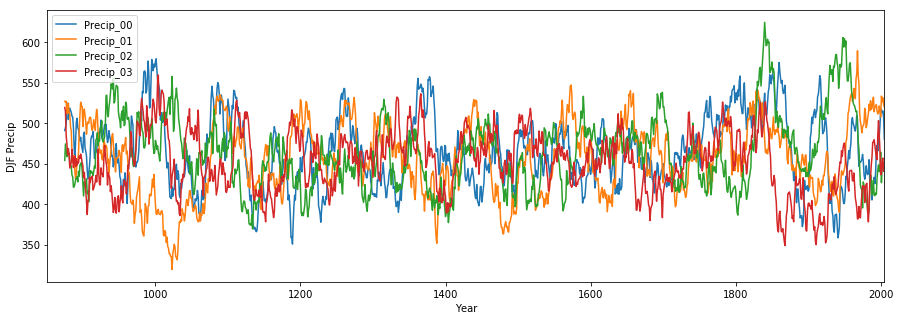

In [5]:
rain_data.rolling(25).mean().plot(figsize=(15, 5))
plt.ylabel("DJF Precip")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fd00dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a987860>]], dtype=object)

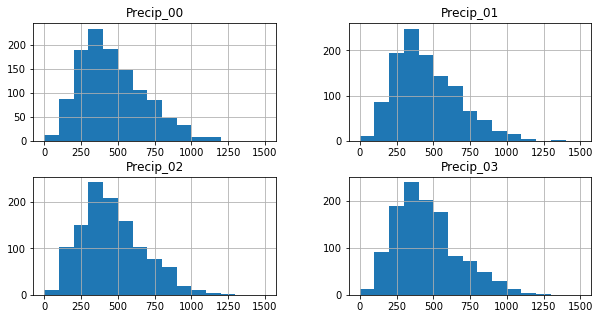

In [6]:
rain_data.hist(bins=np.arange(0, 1600, 100), figsize=(10, 5))